![](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/06/deeplab.png)

# Сегментация в tensorflow 

В этом скрипте мы будем заниматься задачей, связанной с сегментацией изображения. Мы попробуем разные подходы. Во-первых, вороство с последующей доработкой. Во-вторых, свою собственную кастомную модель.

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

print(tf.__version__)

2.1.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Что будем сегментировать? 

Для начала попробуем собирать сетки самостоятельно. Не так давно на kaggle висело [соревнование,](https://www.kaggle.com/c/airbus-ship-detection) в котором надо было искать на фотках со спутника, корабли. 

![](https://www.kaggleusercontent.com/kf/6617956/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..8A34ni2NBk_Bl9X9fK-Piw.NYbcAgRfxvUT9lgiaZMsrT7bWsWnHtK_UbS-dcP-nqZblv_r_jBVVVVJ3P2o3PDGBQ_KwxRB7yBvXrovB8MIiOjh1ucR5SOeCk-9GTEX4KOMEASFzwBkVG9pcflh8rLLN2zr3YmcuXVrH80v8iia_Q.YYKBnJsaMRQU_u3bRdXtzA/__results___files/__results___23_2.png)


Мы попробуем решать аналогичную проблему. Правда наши корабли будут фиктивными, потому что мы не хотим себе лишних проблем. Будем искуственно генерировать море и корабль на нём. Генератор урадём с [хабра.](https://habr.com/ru/company/ods/blog/431512/) 

In [3]:
# модуль для генерации элипсов (pip install scikit-image)
from skimage.draw import ellipse, polygon

Море будет белым шумом, корабли будут эллипсами. 

In [4]:
w_size = 128       # размерность картинки 
train_num = 5000   # размерность выборки 

# вектора, куда будем записывать выборку 
train_x = np.zeros((train_num, w_size, w_size,3), dtype='float32')
train_y = np.zeros((train_num, w_size, w_size,1), dtype='float32')

# характеристики для эллипсов-кораблей 
img_l = np.random.sample((w_size, w_size, 3))*0.5
img_h = np.random.sample((w_size, w_size, 3))*0.5 + 0.5

radius_min = 10
radius_max = 30

Пишем генератор.

In [5]:
def next_pair(w_size, img_l, img_h):
    # r,c - координаты центра эллипса
    r = np.random.sample()*(w_size-2*radius_max) + radius_max
    c = np.random.sample()*(w_size-2*radius_max) + radius_max
    
    # большой и малый радиусы эллипса
    r_radius = np.random.sample()*(radius_max-radius_min) + radius_min
    c_radius = np.random.sample()*(radius_max-radius_min) + radius_min
    
    rot = np.random.sample()*360 #  наклон эллипса
    rr, cc = ellipse(
      r, c, 
      r_radius, c_radius, 
      rotation=np.deg2rad(rot), 
      shape=img_l.shape
    )  # получаем все точки эллипса

    # красим пиксели моря/фона в шум от 0.5 до 1.0
    img = img_h.copy()
    
    # красим пиксели эллипса в шум от 0.0  до 0.5
    img[rr, cc] = img_l[rr, cc]
    
    msk = np.zeros((w_size, w_size, 1), dtype='float32')
    msk[rr, cc] = 1. # красим пиксели маски эллипса
    
    return img, msk # на выходе два объекта, картинка и сегментироанный ответ на неё

Давайте сгенерируем море и корабли на нём, а после посмотрим на несколько примеров. 

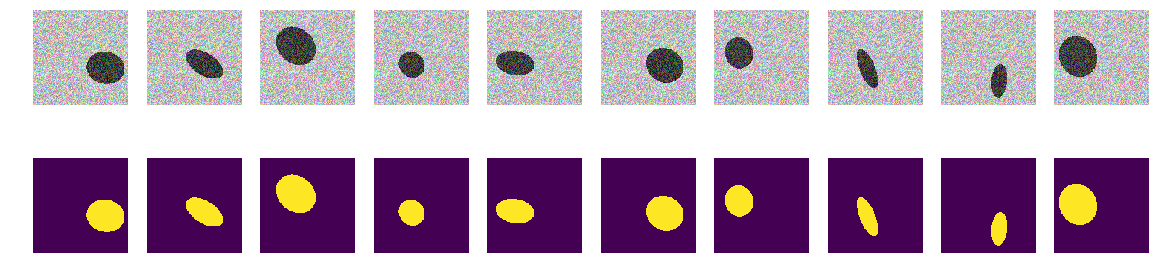

In [6]:
for k in range(train_num): # генерация всех img train
    img, msk = next_pair(w_size, img_l, img_h)
    
    train_x[k] = img
    train_y[k] = msk

fig, axes = plt.subplots(2, 10, figsize=(20, 5)) # смотрим на первые 10 с масками
for k in range(10):
    axes[0,k].set_axis_off()
    axes[0,k].imshow(train_x[k])
    axes[1,k].set_axis_off()
    axes[1,k].imshow(train_y[k].squeeze())

In [7]:
train_x[0]

array([[[0.8066321 , 0.54838747, 0.6859484 ],
        [0.6715785 , 0.70009875, 0.8307064 ],
        [0.9525532 , 0.9941937 , 0.7887979 ],
        ...,
        [0.67355007, 0.98742265, 0.7276949 ],
        [0.70227563, 0.9427653 , 0.86134404],
        [0.78266966, 0.7852542 , 0.578692  ]],

       [[0.5646819 , 0.53713167, 0.6063564 ],
        [0.7355806 , 0.5523555 , 0.5919931 ],
        [0.99756074, 0.7043881 , 0.7810335 ],
        ...,
        [0.5266032 , 0.6051736 , 0.92737365],
        [0.87647897, 0.8834456 , 0.5904237 ],
        [0.6089038 , 0.91447276, 0.80504125]],

       [[0.6214684 , 0.76500726, 0.5218097 ],
        [0.76411927, 0.9018254 , 0.88801736],
        [0.75353616, 0.8994212 , 0.93860906],
        ...,
        [0.98750335, 0.62090635, 0.74750435],
        [0.6087171 , 0.57301605, 0.55491537],
        [0.5855522 , 0.75471073, 0.5499653 ]],

       ...,

       [[0.7771613 , 0.75106287, 0.6081065 ],
        [0.8251121 , 0.99712396, 0.5041432 ],
        [0.7310185 , 0

In [8]:
train_y[0].tolist()

[[[0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
 

На таких парах из картинок мы и будем обучать наши нейросетки. На вход поступает море с кораблём, на выходе оказывается изображение, раскрашенное в два цвета-сегмента. В качестве прогноза мы на выходе будем получать вероятность того, что конкретный пиксель относится к конкретному сегменту. Ошибку будем считать с помощью logloss. 

# 2. Fully convolutional network 

Первой сеткой, которую мы попробуем самостоятельно собрать в Keras, станет [Fully convolutional network](https://arxiv.org/pdf/1605.06211.pdf) 

<img align="center" src="https://www.lri.fr/~gcharpia/deeppractice/images/conv-deconv.png" width="800">



Идея сетки простая. Она состоит из двух частей. Первая часть сворачивает исходное изображение в скрытое представление, то есть это как раз наш экстрактор фичей. Мы его даже из VGG срезали в предыдущей тетрадке. Вторая часть берёт это скрытое представление, разворачивает его назад к исходной размерности, а дальше пытается попиксельно построить прогноз: какая именно область соответствует данному пикселю. Благодяря экстрактору фичей в каждой клетке сетки стоят числа, которые как-то сигнализируют о том, что за объект находится в выделенной области. 

Собираем сетку в Keras. 

In [9]:
import keras.backend as K

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation
from tensorflow.keras.layers import UpSampling2D, BatchNormalization, concatenate

Using TensorFlow backend.


In [28]:
train_y.shape[1:]

(128, 128, 1)

In [10]:
TARGET_WIDTH , TARGET_HEIGHT, IMG_CHANNELS = train_x.shape[1:]

# Вход в сетку 
inputs = Input((TARGET_WIDTH , TARGET_HEIGHT, IMG_CHANNELS))

# 128
down1 = Conv2D(64, (3, 3), activation="relu", padding='same')(inputs)
down1 = BatchNormalization()(down1)
down1 = Conv2D(64, (3, 3), activation="relu", padding='same')(down1)
down1 = BatchNormalization()(down1)
down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)

# 64
down2 = Conv2D(128, (3, 3), activation="relu", padding='same')(down1_pool)
down2 = BatchNormalization()(down2)
down2 = Conv2D(128, (3, 3), activation="relu", padding='same')(down2)
down2 = BatchNormalization()(down2)
down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)

# 32
down3 = Conv2D(256, (3, 3), activation="relu", padding='same')(down2_pool)
down3 = BatchNormalization()(down3)
down3 = Conv2D(256, (3, 3), activation="relu", padding='same')(down3)
down3 = BatchNormalization()(down3)
down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)

# 16
down4 = Conv2D(512, (3, 3), activation="relu", padding='same')(down3_pool)
down4 = BatchNormalization()(down4)
down4 = Conv2D(512, (3, 3), activation="relu", padding='same')(down4)
down4 = BatchNormalization()(down4)
down4_pool = MaxPooling2D((2, 2), strides=(2, 2))(down4)

# 8
center = Conv2D(1024, (3, 3), activation="relu", padding='same')(down4_pool)
center = BatchNormalization()(center)
center = Conv2D(1024, (3, 3), activation="relu", padding='same')(center)
center = BatchNormalization()(center)

# center

up4 = UpSampling2D((2, 2))(center)
up4 = Conv2D(512, (3, 3), activation="relu", padding='same')(up4)
up4 = BatchNormalization()(up4)
up4 = Conv2D(512, (3, 3), activation="relu", padding='same')(up4)
up4 = BatchNormalization()(up4)
up4 = Conv2D(512, (3, 3), activation="relu", padding='same')(up4)
up4 = BatchNormalization()(up4)

# 16
up3 = UpSampling2D((2, 2))(up4)
up3 = Conv2D(256, (3, 3), activation="relu", padding='same')(up3)
up3 = BatchNormalization()(up3)
up3 = Conv2D(256, (3, 3), activation="relu",  padding='same')(up3)
up3 = BatchNormalization()(up3)
up3 = Conv2D(256, (3, 3), activation="relu", padding='same')(up3)
up3 = BatchNormalization()(up3)

# 32
up2 = UpSampling2D((2, 2))(up3)
up2 = Conv2D(128, (3, 3), activation="relu", padding='same')(up2)
up2 = BatchNormalization()(up2)
up2 = Conv2D(128, (3, 3), activation="relu", padding='same')(up2)
up2 = BatchNormalization()(up2)
up2 = Conv2D(128, (3, 3), activation="relu", padding='same')(up2)
up2 = BatchNormalization()(up2)

# 64
up1 = UpSampling2D((2, 2))(up2)
up1 = Conv2D(64, (3, 3), activation="relu", padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Conv2D(64, (3, 3), activation="relu", padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Conv2D(64, (3, 3), activation="relu", padding='same')(up1)
up1 = BatchNormalization()(up1)

# 128
outputs = Conv2D(1, (1, 1), activation='sigmoid')(up1)
model_fully = Model(inputs=inputs, outputs=outputs)

In [11]:
optimizer = tf.optimizers.Adam()

model_fully.compile(
    optimizer=optimizer, 
    loss="binary_crossentropy", 
    metrics=["accuracy"]
)

In [12]:
history = model_fully.fit(train_x, train_y,
                    batch_size=16,
                    epochs=1,
                    validation_split=0.1
                   )

Train on 4500 samples, validate on 500 samples
4500/4500 [==============================] - 195s 43ms/sample - loss: 0.0946 - accuracy: 0.9836 - val_loss: 0.1386 - val_accuracy: 0.9726


In [22]:
test_img, test_mask = next_pair(w_size, img_l, img_h)
test_predict = model_fully.predict(test_img[np.newaxis, ...])[0]



In [26]:
test_predict

array([[[0.02002378],
        [0.00310839],
        [0.00248003],
        ...,
        [0.00340367],
        [0.00554781],
        [0.05142807]],

       [[0.00383619],
        [0.00234645],
        [0.00259121],
        ...,
        [0.00276581],
        [0.00251127],
        [0.00633652]],

       [[0.00350298],
        [0.00257076],
        [0.00247186],
        ...,
        [0.00245505],
        [0.00258302],
        [0.00387606]],

       ...,

       [[0.00349468],
        [0.00262988],
        [0.00194028],
        ...,
        [0.00215759],
        [0.00196361],
        [0.00210103]],

       [[0.00729202],
        [0.00485292],
        [0.00393879],
        ...,
        [0.00261305],
        [0.00187914],
        [0.00345075]],

       [[0.02120925],
        [0.00923078],
        [0.00829887],
        ...,
        [0.00369434],
        [0.00334963],
        [0.01815934]]], dtype=float32)

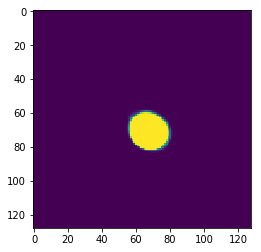

In [23]:
plt.imshow(test_predict.squeeze())

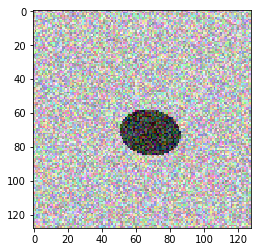

In [24]:
plt.imshow(test_img.squeeze())

In [13]:
np.max(test_predict)

NameError: name 'test_predict' is not defined

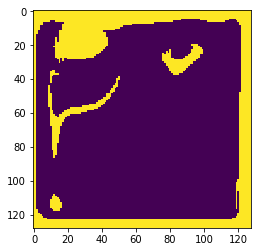

In [95]:
plt.imshow((test_predict > 0.0013).squeeze())

# 3. U-NET

Архитектура, которую мы будем собирать, называется `U-net` и выглядит вот так: 

<img align="center" src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" width="800">

__U-net__ - это свёрточная нейнонка, которую [придумали в 2015 году.](https://arxiv.org/pdf/1505.04597.pdf) Придумали её (шок-контент) биологи для сегментации биомедицинских изображений. Называется сетка так, потому что похожа на букву $U$ (снова шок-контент). 

Информация течёт по сетке слева направо. На каждом шаге число каналов удваивается. В середине (самый низ буквы U) находится скрытое представление входной картинки (те самые фичи, которые на нас выплёвывала VGG-16 в прошлой тетрадке). На следущей паре у вас появится ещё одно объяснении тому, что это такое в середине у сетки. Через автокодировщики.

Фичи, которые нащупал экстрактор, нужно развернуть назад в большое изображение, для которого мы с вами будем строить попиксельные прогнозы. За это отвечает расширяющий путь, который идёт от основания буквы U наверх. Каждый шаг расширяющего пути содержит слой, обратный пулингу. После расширения идёт свёртка, которая уменьшает число каналов. Так происходит до тех пор, пока наши скрытые фичи не развернуться в размерность, соотвествующую исходному изображению. Для каждого писеля в итоговой матрице будет стоять вероятность того, что он относится к тому или иному сегменту, полученная через Softmax. 

Кроме экстрактора и декодера, у сетки есть ещё одна особенность. Между слоями, которые отображают один и тот же уровень абстракции, прокидываются связи. На практике оказывается, что такие связи помогают сетке лучше решать задачу. 

In [54]:
TARGET_WIDTH , TARGET_HEIGHT, IMG_CHANNELS = train_x.shape[1:]

# Вход в сетку 
inputs = Input((TARGET_WIDTH , TARGET_HEIGHT, IMG_CHANNELS))

# 128
down1 = Conv2D(64, (3, 3), activation="relu", padding='same')(inputs)
down1 = BatchNormalization()(down1)
down1 = Conv2D(64, (3, 3), activation="relu", padding='same')(down1)
down1 = BatchNormalization()(down1)
down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)

# 64
down2 = Conv2D(128, (3, 3), activation="relu", padding='same')(down1_pool)
down2 = BatchNormalization()(down2)
down2 = Conv2D(128, (3, 3), activation="relu", padding='same')(down2)
down2 = BatchNormalization()(down2)
down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)

# 32
down3 = Conv2D(256, (3, 3), activation="relu", padding='same')(down2_pool)
down3 = BatchNormalization()(down3)
down3 = Conv2D(256, (3, 3), activation="relu", padding='same')(down3)
down3 = BatchNormalization()(down3)
down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)

# 16
down4 = Conv2D(512, (3, 3), activation="relu", padding='same')(down3_pool)
down4 = BatchNormalization()(down4)
down4 = Conv2D(512, (3, 3), activation="relu", padding='same')(down4)
down4 = BatchNormalization()(down4)
down4_pool = MaxPooling2D((2, 2), strides=(2, 2))(down4)

# 8
center = Conv2D(1024, (3, 3), activation="relu", padding='same')(down4_pool)
center = BatchNormalization()(center)
center = Conv2D(1024, (3, 3), activation="relu", padding='same')(center)
center = BatchNormalization()(center)

# center

up4 = UpSampling2D((2, 2))(center)
up4 = concatenate([down4, up4], axis=3)  # ПРОКИНУЛИ СВЯЗЬ МЕЖДУ СТАРЫМ И НОВЫМ!!! 

up4 = Conv2D(512, (3, 3), activation="relu", padding='same')(up4)
up4 = BatchNormalization()(up4)
up4 = Conv2D(512, (3, 3), activation="relu", padding='same')(up4)
up4 = BatchNormalization()(up4)
up4 = Conv2D(512, (3, 3), activation="relu", padding='same')(up4)
up4 = BatchNormalization()(up4)

# 16
up3 = UpSampling2D((2, 2))(up4)
up3 = concatenate([down3, up3], axis=3) # ПРОКИНУЛИ СВЯЗЬ МЕЖДУ СТАРЫМ И НОВЫМ!!! 

up3 = Conv2D(256, (3, 3), activation="relu", padding='same')(up3)
up3 = BatchNormalization()(up3)
up3 = Conv2D(256, (3, 3), activation="relu",  padding='same')(up3)
up3 = BatchNormalization()(up3)
up3 = Conv2D(256, (3, 3), activation="relu", padding='same')(up3)
up3 = BatchNormalization()(up3)

# 32
up2 = UpSampling2D((2, 2))(up3)
up2 = concatenate([down2, up2], axis=3) # ПРОКИНУЛИ СВЯЗЬ МЕЖДУ СТАРЫМ И НОВЫМ!!! 

up2 = Conv2D(128, (3, 3), activation="relu", padding='same')(up2)
up2 = BatchNormalization()(up2)
up2 = Conv2D(128, (3, 3), activation="relu", padding='same')(up2)
up2 = BatchNormalization()(up2)
up2 = Conv2D(128, (3, 3), activation="relu", padding='same')(up2)
up2 = BatchNormalization()(up2)

# 64
up1 = UpSampling2D((2, 2))(up2)
up1 = concatenate([down1, up1], axis=3) # ПРОКИНУЛИ СВЯЗЬ МЕЖДУ СТАРЫМ И НОВЫМ!!! 

up1 = Conv2D(64, (3, 3), activation="relu", padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Conv2D(64, (3, 3), activation="relu", padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Conv2D(64, (3, 3), activation="relu", padding='same')(up1)
up1 = BatchNormalization()(up1)

# 128
outputs = Conv2D(1, (1, 1), activation='sigmoid')(up1)
model_unet = Model(inputs=inputs, outputs=outputs)

In [55]:
optimizer = tf.train.AdamOptimizer()

model_unet.compile(
    optimizer=optimizer, 
    loss="binary_crossentropy", 
    metrics=["accuracy"]
)

In [56]:
history = model_unet.fit(train_x, train_y,
                    batch_size=32,
                    epochs=1,
                    validation_split=0.1
                   )

Train on 4500 samples, validate on 500 samples
4500/4500 [==============================] - 6346s 1s/sample - loss: 2.4741 - acc: 0.9888 - val_loss: 14.2946 - val_acc: 0.9232


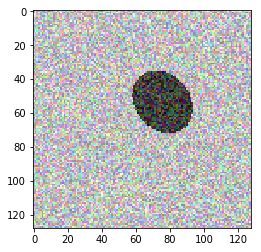

In [58]:
test_img, test_mask = next_pair()
test_predict = model_unet.predict(test_img[np.newaxis, ...])[0]

plt.imshow(test_img.squeeze())

In [60]:
np.max(test_predict)

0.10604352

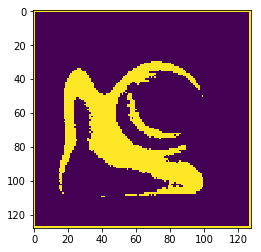

In [77]:
plt.imshow((test_predict > 0.004 ).squeeze())

# 4.  Transfer learning 

Одна эпоха, учится довольно долго. Не очень приятно. Давайте попробуем сделать transfer learning. __Его вы сделаете самостоятельно.__ Весь необходимый для этого код у вас имеется. Осталось только внимательно следовать моим инструкциям и собрать свою собственную нейронку для сегментации изображений. Мы будем делать эту сборку на основе __VGG-16.__ Собтрать будем fully conected сетку.

Подгрузите из Keras предобученную на ImageNet __VGG-16.__ Выведите на экран `summary` модели.

In [15]:
from tensorflow.python.keras.applications import VGG16
model_vgg = VGG16(include_top=True, weights='imagenet')
model_vgg.summary()

Instructions for updating:
Colocations handled automatically by placer.


W0516 00:07:45.019057 140736315745216 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/resource_variable_ops.py:435: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Вынесите в отдельнуык вершины слои `input_?, block3_pool, block4_pool, block5_pool`.

In [17]:
transfer_layer_input = model_vgg.get_layer('input_1')
transfer_layer_3 = model_vgg.get_layer('block3_pool')
transfer_layer_4 = model_vgg.get_layer('block4_pool')
transfer_layer_5 = model_vgg.get_layer('block5_pool')

Выходы с 3 и 4 слоёв нам не понадобятся. Тем не менее, если захочется собирать U-netб их можно будет прокидывать к соответствующим уровням абстракции на выход. Размерности выходов:

In [18]:
# рзмер входа 
transfer_layer_input.input

<tf.Tensor 'input_1:0' shape=(?, 224, 224, 3) dtype=float32>

In [19]:
# размерности выходов
print(transfer_layer_3.output)
print(transfer_layer_4.output)
print(transfer_layer_5.output)

Tensor("block3_pool/MaxPool:0", shape=(?, 28, 28, 256), dtype=float32)
Tensor("block4_pool/MaxPool:0", shape=(?, 14, 14, 512), dtype=float32)
Tensor("block5_pool/MaxPool:0", shape=(?, 7, 7, 512), dtype=float32)


Собираем Экстрактор. Сделать это нужно из VGG-16.

In [20]:
from tensorflow.python.keras.models import Model
extractor = Model(inputs=model_vgg.input, outputs=transfer_layer_5.output)

Собираем саму по себе модельку. Например, такую:

In [23]:
print(inputs)
print(center)
print(up4)
print(up3)
print(up2)
print(up1)
print(outputs)

Tensor("input_2:0", shape=(?, 224, 224, 3), dtype=float32)
Tensor("model/block5_pool/MaxPool:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("batch_normalization_v1_1/cond/Merge:0", shape=(?, 28, 28, 512), dtype=float32)
Tensor("batch_normalization_v1_2/cond/Merge:0", shape=(?, 56, 56, 512), dtype=float32)
Tensor("batch_normalization_v1_3/cond/Merge:0", shape=(?, 112, 112, 512), dtype=float32)
Tensor("batch_normalization_v1_4/cond/Merge:0", shape=(?, 224, 224, 512), dtype=float32)
Tensor("conv2d_5/Sigmoid:0", shape=(?, 224, 224, 1), dtype=float32)


Эта архитектурка не очень то зеркалит VGG-16, но да ладно. 

In [22]:
inputs = Input((transfer_layer_input.input_shape[1:]))

center = extractor(inputs)

up5 = UpSampling2D((2, 2))(center)
up5 = Conv2D(512, (3, 3), activation="relu", padding='same')(up5)
up5 = BatchNormalization()(up5)

up4 = UpSampling2D((2, 2))(up5)
up4 = Conv2D(512, (3, 3), activation="relu", padding='same')(up4)
up4 = BatchNormalization()(up4)

up3 = UpSampling2D((2, 2))(up4)
up3 = Conv2D(512, (3, 3), activation="relu", padding='same')(up3)
up3 = BatchNormalization()(up3)

up2 = UpSampling2D((2, 2))(up3)
up2 = Conv2D(512, (3, 3), activation="relu", padding='same')(up2)
up2 = BatchNormalization()(up2)

up1 = UpSampling2D((2, 2))(up2)
up1 = Conv2D(512, (3, 3), activation="relu", padding='same')(up1)
up1 = BatchNormalization()(up1)

# 128
outputs = Conv2D(1, (1, 1), activation='sigmoid')(up1)
model_vgg_fully = Model(inputs=inputs, outputs=outputs)

Теперь оптимизатор.

In [24]:
optimizer = tf.train.AdamOptimizer()

model_vgg_fully.compile(
    optimizer=optimizer, 
    loss="binary_crossentropy", 
    metrics=["accuracy"]
)

Делать resize наших кораблей через `PIL` как в семинаре по `transfer learning` лениво. Просто сгенерим новую выборку. 

In [27]:
w_size = 224     # размерность картинки 

# характеристики для эллипсов-кораблей 
img_l = np.random.sample((w_size, w_size, 3))*0.5
img_h = np.random.sample((w_size, w_size, 3))*0.5 + 0.5

train_x = np.zeros((train_num, w_size, w_size,3), dtype='float32')
train_y = np.zeros((train_num, w_size, w_size,1), dtype='float32')

for k in range(train_num): # генерация всех img train
    img, msk = next_pair(w_size, img_l, img_h)
    
    train_x[k] = img
    train_y[k] = msk

train_x.shape, train_y.shape

((5000, 224, 224, 3), (5000, 224, 224, 1))

Погнали учить новоиспечённую модель! Если обучение запустится, вы победитель.

In [ ]:
history = model_vgg_fully.fit(train_x, train_y,
                    batch_size=32,
                    epochs=1,
                    validation_split=0.1)

Train on 4500 samples, validate on 500 samples
Instructions for updating:
Use tf.cast instead.


W0516 00:09:33.491016 140736315745216 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


In [ ]:
TARGET_WIDTH , TARGET_HEIGHT, IMG_CHANNELS = (384,384,1)

# Вход в сетку 
inputs = Input((TARGET_WIDTH , TARGET_HEIGHT, IMG_CHANNELS))

# 128
down1 = Conv2D(49, (3, 3), activation="relu", padding='same')(inputs)
down1 = BatchNormalization()(down1)
down1 = Conv2D(49, (3, 3), activation="relu", padding='same')(down1)
down1 = BatchNormalization()(down1)
down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)

# 8
center = Conv2D(98, (3, 3), activation="relu", padding='same')(down1_pool)
center = BatchNormalization()(center)
center = Conv2D(98, (3, 3), activation="relu", padding='same')(center)
center = BatchNormalization()(center)

# 64
up1 = UpSampling2D((2, 2))(center)
up1 = Conv2D(49, (3, 3), activation="relu", padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Conv2D(49, (3, 3), activation="relu", padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Conv2D(49, (3, 3), activation="relu", padding='same')(up1)
up1 = BatchNormalization()(up1)

# 128
outputs = Conv2D(7, (1, 1), activation='sigmoid')(up1)
model_fully = Model(inputs=inputs, outputs=outputs)

__А терерь попробуйте родить U-net из VGG-16.__ Но уже дома.